In [6]:
import tensorflow as tf
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import skimage.transform as tform

In [2]:
p = PLE(FlappyBird(), fps=30, display_screen=False, force_fps=False)

In [3]:
p.init()

In [10]:
%%time

p.reset_game()

games = 1
total_rewards = []

while games < 10:
    action = np.random.choice([0,119], p=[.9,.1])
    reward = p.act(action)
    
    total_rewards.append(reward)
    
    if p.game_over():
        p.reset_game()
        games += 1

CPU times: user 6.34 s, sys: 0 ns, total: 6.34 s
Wall time: 18.1 s


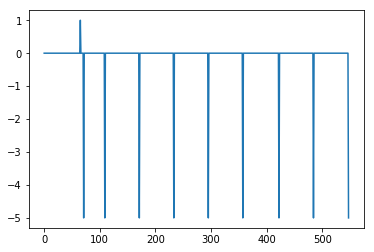

In [11]:
plt.plot(total_rewards)
plt.show()

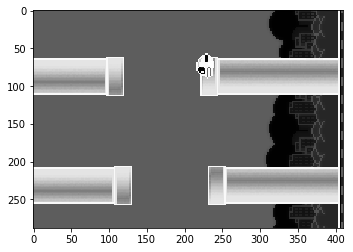

In [13]:
pic = p.getScreenRGB()
plt.imshow(pic[:,:410,1], cmap='Greys')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


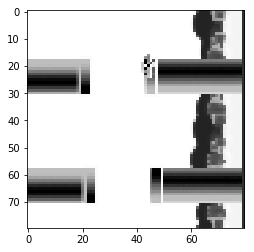

In [19]:
p.reset_game()
pic = p.getScreenRGB()
pic = pic[:,:410,0]
pic = tform.resize(pic, (80,80))
plt.imshow(pic, cmap='Greys')
plt.show()

# policy gradient learner

In [31]:
'''
gamma = 0.99

def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r
'''

def prepro(img):
    img = img[:,:410,1]
    # TODO: velocity transform here. Could be building difference frames or frame stacking.
    img = tform.resize(img, (80,80))
    return np.reshape(img, [1,80,80,1])
    
class agent():
    def __init__(self, lr, s_size, a_size, h_size):
        self.state_in= tf.placeholder(shape=[None, s_size, s_size, 1],dtype=tf.float32)
        
        w1 = tf.Variable(tf.random_normal([8,8,1,32], stddev=1), name='w1')
        w2 = tf.Variable(tf.random_normal([4,4,32,64], stddev=1), name='w2')
        w3 = tf.Variable(tf.random_normal([3,3,64,64], stddev=1), name='w3')
        w4 = tf.Variable(tf.random_normal([3*3*64, 512], stddev=1), name='w4')
        w5 = tf.Variable(tf.random_normal([512, 2], stddev=1), name='w5')
        
        conv1 = tf.nn.relu(tf.nn.conv2d(self.state_in, filter=w1, strides=[1,4,4,1], padding='SAME'))
        conv2 = tf.nn.relu(tf.nn.conv2d(conv1, filter=w2, strides=[1,2,2,1], padding='SAME'))
        conv3 = tf.nn.relu(tf.nn.conv2d(conv2, filter=w3, strides=[1,1,1,1], padding='SAME'))
        flat = tf.reshape(conv3, [-1, 3 * 3 * 64])
        dense1 = tf.nn.relu(tf.matmul(flat, w4))
        self.output = tf.nn.softmax(tf.matmul(dense1, w5))
        
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
        
tf.reset_default_graph()

myAgent = agent(lr=0.01, s_size=80, a_size=2, h_size=8)

total_episodes = 100
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        p.reset_game()
        s = prepro(p.getScreenRGB())
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:s})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            print('alkjadn;jkafnano')
            
            r = p.act(a)
            s1 = prepro(p.getScreenRGB())
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if p.game_over() == True:
                ep_history = np.array(ep_history)
                #ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        if i % 100 == 0:
            print(np.mean(total_reward[-100:]))
        i += 1

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


InvalidArgumentError: Input to reshape is a tensor with 6400 values, but the requested shape requires a multiple of 576
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Relu_2, Reshape/shape)]]

Caused by op 'Reshape', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-23688f0b794a>", line 57, in <module>
    myAgent = agent(lr=0.01, s_size=80, a_size=2, h_size=8)
  File "<ipython-input-31-23688f0b794a>", line 32, in __init__
    flat = tf.reshape(conv3, [-1, 3 * 3 * 64])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2619, in reshape
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 6400 values, but the requested shape requires a multiple of 576
	 [[Node: Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Relu_2, Reshape/shape)]]
